In [1]:
'''
    Description:
     - Create a fresh Python project (either .py or .ipynb) that does the following:
     - Downloads a clustering data set from the UCI Machine Learning Repository.
     - Performs clustering on the data (please include an explanation of why you selected that particular clustering algorithm for this problem).
     - Plots the clusters and provides a textual interpretation of the results.
     - Transforms the cluster labels into target variables for classification.
     - Performs classification on the data using the new categorical target values 
     (please include an explanation of why you selected that particular classification algorithm).
     - Evaluates the performance of the classifier and provides some textual interpretation.
     - Includes a sketched-out diagram (e.g. using Google draw or on paper/whiteboard) 
     of a pipeline that integrates the above steps so that the model could be rebuilt on demand 
     (e.g. in a production environment).
     - Save your file(s), upload them to a Github repository, and send us the link!
     
    Author: Oyesh Mann Singh
    
    Date: 12/22/2018
'''

import os
import sys
import pickle

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MeanShift, MiniBatchKMeans, estimate_bandwidth
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read the iris data directly from UCI Machine Learning Repository
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                 header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Get the categorical values
classes = list(df['class'].unique())
classes

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [5]:
# Check the data distribution based on target value
print(df.groupby('class').count())

                 sepal_length  sepal_width  petal_length  petal_width
class                                                                
Iris-setosa                50           50            50           50
Iris-versicolor            50           50            50           50
Iris-virginica             50           50            50           50


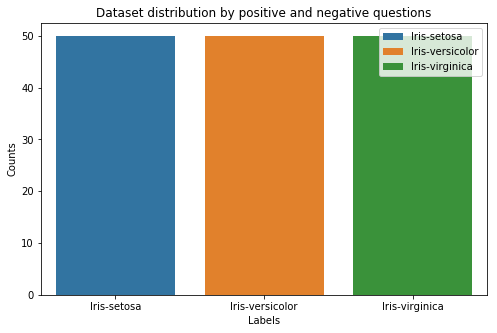

In [6]:
# Plot histogram of datapoint based on class
def plot_dist(data=df):
    fig = plt.figure(figsize=(8,5))
    uniques = data['class'].unique()
    counts = data['class'].value_counts()
    ax = sns.barplot(x=uniques,y=counts, dodge=False, hue=[0,1,2])

    ax.set(xlabel='Labels')
    ax.set(ylabel='Counts')
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ['Iris-setosa','Iris-versicolor', 'Iris-virginica'])
    plt.title('Dataset distribution by positive and negative questions')
    plt.show()
    
plot_dist()

In [7]:
'''
    To save the trained model in pickle format
    and load it back
'''

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

def save_model(model, filename='model.pkl'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename='model.pkl'):
    return pickle.load(open(filename, 'rb'))

In [8]:
# Elbow method to find the best number of cluster to use
wcss = []
elbow_x = df.iloc[:, [0,1,2,3]].values

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 123)
    kmeans.fit(elbow_x)
    wcss.append(kmeans.inertia_)

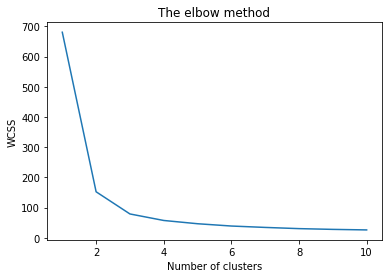

In [9]:
# Plot of elbow method
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [10]:
# Change labels to numbers
df = df.replace('Iris-setosa', 0).replace('Iris-versicolor', 1).replace('Iris-virginica', 2)

In [11]:
# Check the sample of replaced dataframe
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,class
105,7.6,3.0,6.6,2.1,2
94,5.6,2.7,4.2,1.3,1
32,5.2,4.1,1.5,0.1,0
59,5.2,2.7,3.9,1.4,1
3,4.6,3.1,1.5,0.2,0


In [12]:
# Split train/test -> 75/25
def split_train_test(df, test_size=0.25):
    train, test = train_test_split(df, test_size=test_size, random_state=3)
    return train.reset_index(drop=True), test.reset_index(drop=True)

train_df, test_df = split_train_test(df)

print(train_df.shape)
print(test_df.shape)

(112, 5)
(38, 5)


In [13]:
# Separate features and targets
train_class = train_df['class'].values
train_features = train_df.iloc[:, [0,1,2,3]].values

test_class = test_df['class'].values
test_features = test_df.iloc[:, [0,1,2,3]].values

In [14]:
train_class

array([2, 1, 2, 1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 0, 2, 1, 1, 0, 2, 0, 2, 1,
       0, 0, 2, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0,
       2, 2, 1, 2, 1, 2, 0, 2, 0, 1, 1, 2, 2, 0, 1, 0, 1, 1, 1, 0, 2, 0,
       2, 1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1, 2, 0,
       0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 2, 2, 2, 0, 0,
       2, 2], dtype=int64)

## Visualising the clusters

In [15]:
#Visualising the clusters

def plot_data(features, class_type, pred=False):
    # Set the size of the plot
    plt.figure(figsize=(14,7))

    # Plotting based on petal length and width
    plt.subplot(1,2,1)
    plt.scatter(features[class_type == 0, 0], features[class_type == 0, 1], s = 50, c = 'red', label = 'Iris-setosa')
    plt.scatter(features[class_type == 1, 0], features[class_type == 1, 1], s = 50, c = 'blue', label = 'Iris-versicolor')
    plt.scatter(features[class_type == 2, 0], features[class_type == 2, 1], s = 50, c = 'green', label = 'Iris-virginica')

    #Plotting the centroids of the clusters
    if pred == True:
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
    plt.title('Plotting based on Sepal Length and Width')
    plt.legend()


    # Plotting based on petal length and width
    plt.subplot(1,2,2)
    plt.scatter(features[class_type == 0, 2], features[class_type == 0, 3], s = 50, c = 'red', label = 'Iris-setosa')
    plt.scatter(features[class_type == 1, 2], features[class_type == 1, 3], s = 50, c = 'blue', label = 'Iris-versicolor')
    plt.scatter(features[class_type == 2, 2], features[class_type == 2, 3], s = 50, c = 'green', label = 'Iris-virginica')

    #Plotting the centroids of the clusters
    if pred == True:
        plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:,3], s = 100, c = 'yellow', label = 'Centroids')
    plt.title('Plotting based on Petal Length and Width')
    plt.legend()
    

# Check the accuracy
def check_accuracy(predicted, ground_truth):
    acc = 0
    for y_pred, y_gt in zip(predicted, ground_truth):
        if y_pred == y_gt:
            acc += 1
        
    total_acc = acc / len(ground_truth)
    
    return total_acc * 100

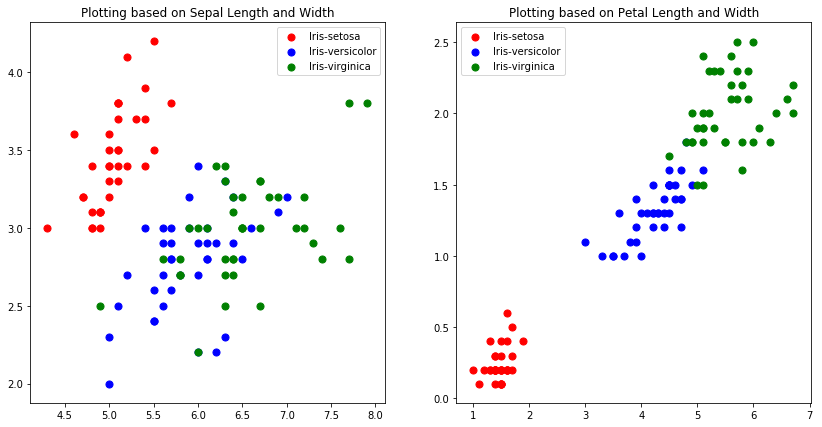

In [16]:
plot_data(train_features, train_class, pred=False)

# MACHINE LEARNING

In [17]:
'''
    Train the model if only the file is not present
'''
def train_model(model, filepath, features=train_features, labels=train_class):
    if os.path.exists(filepath):
        model = load_model(filepath)
    else:
        model.fit(features, labels)
        save_model(model=model, filename=filepath)
        
    return model

## KMEANS CLUSTERING

In [18]:
# Applying kmeans to the dataset / Creating the kmeans classifier
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 100, n_init = 20, random_state = 123)

kmeans_file = 'kmeans.pkl'
kmeans_path = os.path.join(model_dir, kmeans_file)

kmeans = train_model(model=kmeans, filepath=kmeans_path)

y_kmeans = kmeans.predict(train_features)

In [19]:
y_kmeans

array([2, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 1, 2, 0,
       1, 1, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1,
       2, 2, 2, 2, 0, 2, 1, 0, 1, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 1, 2, 1,
       2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1,
       2, 0])

In [20]:
# https://stackoverflow.com/a/44912014/4595807
def transform_kmeans_labels(model, results):
    idx = np.argsort(model.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(n_clusters)
    return lut[results]

In [21]:
y_kmeans = transform_kmeans_labels(kmeans, y_kmeans)

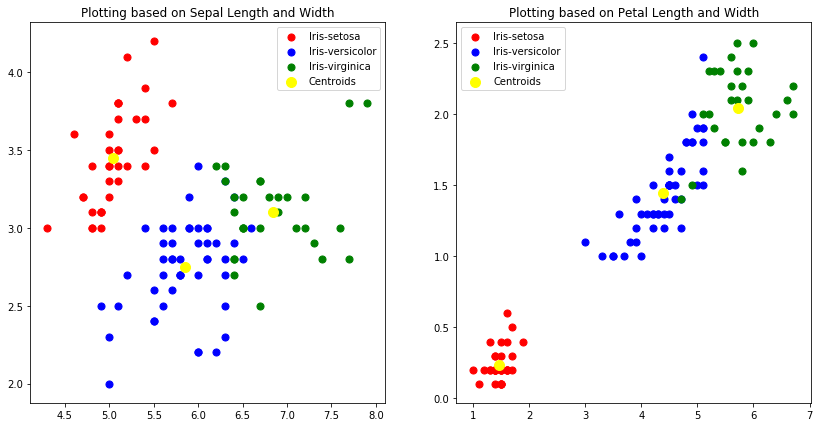

In [22]:
# Plot the predicted data
plot_data(train_features, y_kmeans, pred=True)

In [23]:
# Check accuracy
print('Kmeans training accuracy in (%): ', check_accuracy(y_kmeans, ground_truth=train_class))

Kmeans training accuracy in (%):  87.5


In [24]:
sm.confusion_matrix(y_pred=y_kmeans, y_true=train_class)

array([[35,  0,  0],
       [ 0, 36,  2],
       [ 0, 12, 27]], dtype=int64)

In [25]:
test_pred = kmeans.predict(test_features)
test_pred = transform_kmeans_labels(kmeans, test_pred)

In [26]:
print('Kmeans testing accuracy in (%): ', check_accuracy(predicted=test_pred, ground_truth=test_class))

Kmeans testing accuracy in (%):  92.10526315789474


#### I have chosen kmeans algorithm because it is very simple to understand and also the data used here is small dataset. Kmeans algorithm converges faster and gives higher accuracy on par with other algorithms like mean-shift  and minibatch kmeans

In [27]:
from yellowbrick.classifier import PrecisionRecallCurve

def visualize_roc(model):
    viz = PrecisionRecallCurve(model, per_class=True, 
                           iso_f1_curves=True, fill_area=False, 
                           micro=False)
    
    viz.fit(train_features, train_class)
    viz.score(test_features, test_class)
    viz.poof()

# CLASSIFICATION SECTION

In [28]:
'''
    Support Vector Machine
'''

from sklearn.svm import SVC


svm = SVC(gamma='auto')

svm_file = 'svm.pkl'
svm_path = os.path.join(model_dir, svm_file)

svm = train_model(model=svm, filepath=svm_path)

svm_pred = svm.predict(test_features)

print('SVM accuracy in (%): ', check_accuracy(predicted=svm_pred, ground_truth=test_class))

SVM accuracy in (%):  97.36842105263158


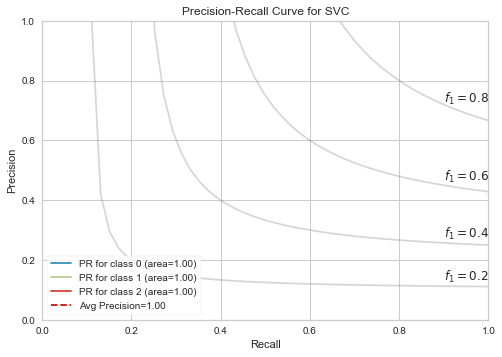

In [29]:
# Visualize ROC
visualize_roc(model=svm)

In [30]:
'''
    Logistic Regression
'''

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

logreg = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

logreg_file = 'logreg.pkl'
logreg_path = os.path.join(model_dir, logreg_file)

logreg = train_model(model=logreg, filepath=logreg_path)

logreg_pred = logreg.predict(test_features)

print('OVR Logistic Regression accuracy in (%): ', check_accuracy(predicted=logreg_pred, ground_truth=test_class))

OVR Logistic Regression accuracy in (%):  100.0


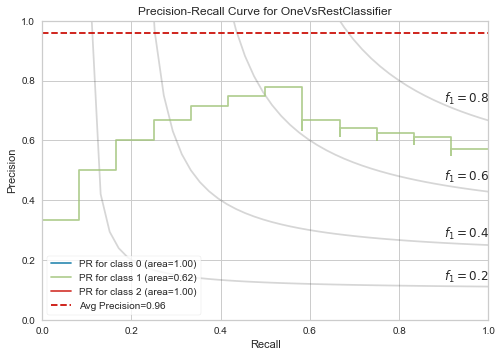

In [31]:
visualize_roc(model=logreg)

In [32]:
'''
    Perceptron
'''

from sklearn.linear_model import Perceptron

percept = Perceptron(tol=1e-3, random_state=3)

percept_file = 'percept.pkl'
percept_path = os.path.join(model_dir, percept_file)

percept = train_model(model=percept, filepath=percept_path)

percept_pred = percept.predict(test_features)

print('Perceptron accuracy in (%): ', check_accuracy(predicted=percept_pred, ground_truth=test_class))

Perceptron accuracy in (%):  100.0


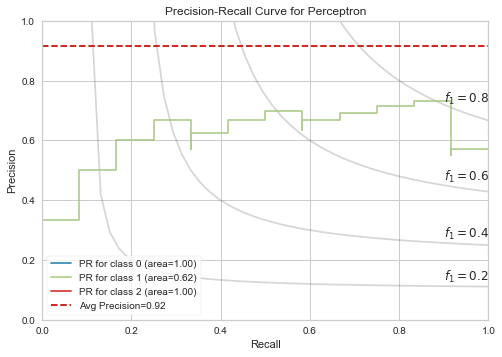

In [33]:
visualize_roc(model=percept)

MLP accuracy in (%):  97.36842105263158


C:\Users\uttam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\uttam\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


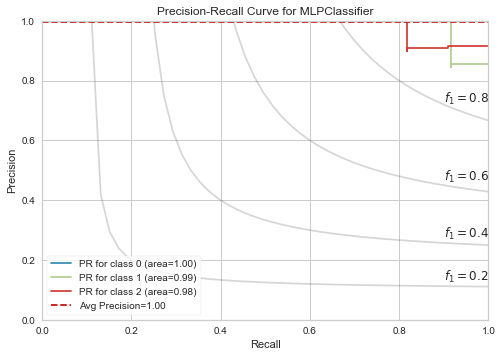

In [34]:
'''
    Multi Layered Perceptron - sgd
'''

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='sgd', alpha=1e-3, hidden_layer_sizes=(15, 5, 2), max_iter=1000, random_state=3)

mlp_file = 'mlp.pkl'
mlp_path = os.path.join(model_dir, mlp_file)

mlp = train_model(model=mlp, filepath=mlp_path)

mlp_pred = mlp.predict(test_features)

print('MLP accuracy in (%): ', check_accuracy(predicted=mlp_pred, ground_truth=test_class))

visualize_roc(mlp)

In [35]:
# Create a random 2D array to see, what it predicts
record = np.array([[5.1,3.5,1.4,4.2]])
mlp.predict(record)

array([1], dtype=int64)

MultinomialNB accuracy in (%):  94.73684210526315


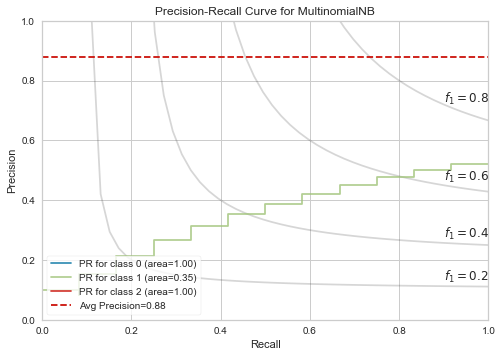

In [36]:
'''
    Multinomial Naive Bayes
'''

from sklearn.naive_bayes import MultinomialNB, BernoulliNB 

mnb = MultinomialNB()

mnb_file = 'mnb.pkl'
mnb_path = os.path.join(model_dir, mnb_file)

mnb = train_model(model=mnb, filepath=mnb_path)

mnb_pred = mnb.predict(test_features)

print('MultinomialNB accuracy in (%): ', check_accuracy(predicted=mnb_pred, ground_truth=test_class))

visualize_roc(mnb)

Bernoulli Naive Bayes accuracy in (%):  28.947368421052634


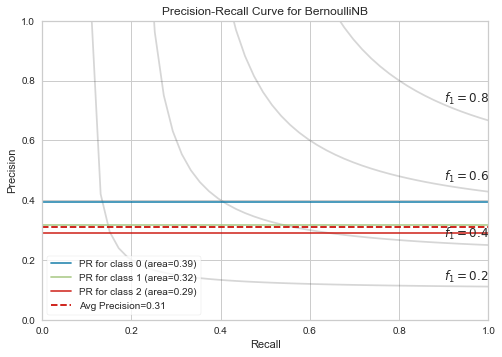

In [37]:
'''
    Bernoulli Naive Bayes
'''

from sklearn.naive_bayes import BernoulliNB 

bnb = BernoulliNB()

bnb_file = 'bnb.pkl'
bnb_path = os.path.join(model_dir, bnb_file)

bnb = train_model(model=bnb, filepath=bnb_path)

bnb_pred = bnb.predict(test_features)

print('Bernoulli Naive Bayes accuracy in (%): ', check_accuracy(predicted=bnb_pred, ground_truth=test_class))

visualize_roc(bnb)

Decision Tree Classifier accuracy in (%):  94.73684210526315


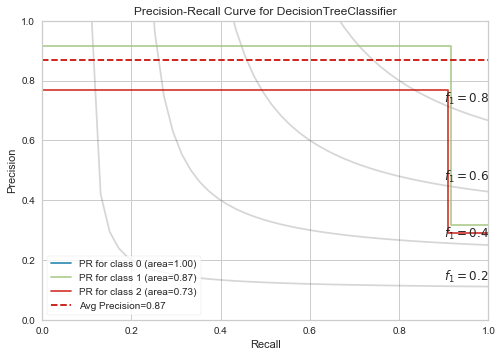

In [38]:
'''
    Decision Tree Classifier
'''

from sklearn.tree import DecisionTreeClassifier 

dtree = DecisionTreeClassifier()

dtree_file = 'dtree.pkl'
dtree_path = os.path.join(model_dir, dtree_file)

dtree = train_model(model=dtree, filepath=dtree_path)

dtree_pred = dtree.predict(test_features)

print('Decision Tree Classifier accuracy in (%): ', check_accuracy(predicted=dtree_pred, ground_truth=test_class))

visualize_roc(dtree)

#### I have tested Iris dataset on SVM, Logistic Regression, Perceptron and MultiLayer Perceptron for classification purpose. Among them Logistic Regression and Perceptron has the highest validation accuracy. If I had to do classification on Iris dataset, I would select  SVM because as you can see it has high precision and recall for each class although it has a bit less accuracy compared to others.